In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Dense, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Without Sentiment

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

stock_price = pdr.get_data_yahoo("TSLA", start = '2017-01-01', end = "2022-05-07")

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_price = stock_price.drop_duplicates()

# dropping the zero values from volume
stock_price = stock_price[stock_price['Volume'] != 0]

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2017-01-03,43.397999,42.972000,44.066002,42.192001,29616500
2017-01-04,45.397999,42.950001,45.599998,42.862000,56067500
2017-01-05,45.349998,45.284000,45.495998,44.389999,29558500
2017-01-06,45.801998,45.386002,46.062000,45.090000,27639500
2017-01-09,46.256001,45.793999,46.383999,45.599998,19897500
...,...,...,...,...,...
2022-05-02,902.940002,860.770020,906.359985,848.030029,25260500
2022-05-03,909.250000,903.179993,924.080017,888.590027,21236500
2022-05-04,952.619995,903.940002,955.500000,885.280029,27214600


In [ ]:
stock_data = stock_price

In [ ]:
stock_data= stock_data.astype({"Volume":'float'})

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1346 entries, 2017-01-03 to 2022-05-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1346 non-null   float64
 1   Open    1346 non-null   float64
 2   High    1346 non-null   float64
 3   Low     1346 non-null   float64
 4   Volume  1346 non-null   float64
dtypes: float64(5)
memory usage: 63.1 KB


In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1076
Number of records in Test Data: 270


In [ ]:
stock_data['Close_EWMA3'] = stock_data['Close'].ewm(span=3, adjust=False).mean()
stock_data['Close_EWMA7'] = stock_data['Close'].ewm(span=7, adjust=False).mean()
stock_data['Close_EWMA14'] = stock_data['Close'].ewm(span=14, adjust=False).mean()
stock_data['Close_EWMA30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()

In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
open_price = stock_data.iloc[start:total_data,1] #open
high = stock_data.iloc[start:total_data,2] #high
low = stock_data.iloc[start:total_data,3] #low
volume = stock_data.iloc[start:total_data,4] #volume


ewma3_close = stock_data.iloc[start:total_data,5]#exponentially moving average 3days
ewma7_close = stock_data.iloc[start:total_data,6]#exponentially moving average 7days
ewma14_close = stock_data.iloc[start:total_data,7]#exponentially moving average 14days
ewma30_close = stock_data.iloc[start:total_data,8]#exponentially moving average 30days

'\newma3_close = stock_data.iloc[start:total_data,5]#exponentially moving average 3days\newma7_close = stock_data.iloc[start:total_data,6]#exponentially moving average 7days\newma14_close = stock_data.iloc[start:total_data,7]#exponentially moving average 14days\newma30_close = stock_data.iloc[start:total_data,8]#exponentially moving average 30days'

In [ ]:
# printing close price
print("Close Price:")
close_price

Close Price:


Date
2017-01-04     45.397999
2017-01-05     45.349998
2017-01-06     45.801998
2017-01-09     46.256001
2017-01-10     45.973999
                 ...    
2022-05-02    902.940002
2022-05-03    909.250000
2022-05-04    952.619995
2022-05-05    873.280029
2022-05-06    865.650024
Name: Close, Length: 1345, dtype: float64

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price,ewma3_close,
                  ewma7_close,
                  ewma14_close,
                  ewma30_close,  close_price_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price','ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close', 'close_price_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    

In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y_data = y
y

Date
2017-01-04     45.349998
2017-01-05     45.801998
2017-01-06     46.256001
2017-01-09     45.973999
2017-01-10     45.945999
                 ...    
2022-04-29    902.940002
2022-05-02    909.250000
2022-05-03    952.619995
2022-05-04    873.280029
2022-05-05    865.650024
Name: close_price_shifted, Length: 1344, dtype: float64

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price','ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close', 'volume', 'open_price', 'high', 'low']
x = data[cols]

In [ ]:
from sklearn.preprocessing import StandardScaler
# scaling the feature dataset

scaler_x = preprocessing.StandardScaler ()
x = np.array(x).reshape((len(x) ,len(cols)))

# scaling the target variable
scaler_y = preprocessing.StandardScaler ()
y = np.array (y).reshape ((len( y), 1))

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  
y_data = y_data[train_end+1 : len(y)]  
# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1076, 5) and y: (1076, 1)
Number of rows and columns in the Test set X: (267, 5) and y: (267, 1)


In [ ]:
sc = scaler_x.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

sc = scaler_y.fit(y_train)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [ ]:
y_data

Date
2021-04-16    714.630005
2021-04-19    718.989990
2021-04-20    744.119995
2021-04-21    719.690002
2021-04-22    729.400024
                 ...    
2022-04-29    902.940002
2022-05-02    909.250000
2022-05-03    952.619995
2022-05-04    873.280029
2022-05-05    865.650024
Name: close_price_shifted, Length: 267, dtype: float64

In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1076, 5, 1)
Shape of Test set X: (267, 5, 1)


### Model

In [ ]:
import tensorflow as tf
import random 
import os
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

initializer = tf.keras.initializers.GlorotNormal()
model1=Sequential()
model1.add((LSTM(250,return_sequences=True,activation='tanh',kernel_initializer=initializer,input_shape=(len(cols),1))))
model1.add(Dropout(0.4))
model1.add(Flatten())
model1.add(Dense(1, activation = 'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 250)            252000    
                                                                 
 dropout (Dropout)           (None, 5, 250)            0         
                                                                 
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 dense (Dense)               (None, 1)                 1251      
                                                                 
Total params: 253,251
Trainable params: 253,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
model1.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

history = model1.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=250,
    batch_size=16,
    callbacks=callbacks,
    shuffle = False
)

Epoch 1/250
61/61 [==============================] - 4s 27ms/step - loss: 0.2932 - val_loss: 0.9592
Epoch 2/250
61/61 [==============================] - 1s 16ms/step - loss: 0.0963 - val_loss: 0.7391
Epoch 3/250
61/61 [==============================] - 1s 17ms/step - loss: 0.0489 - val_loss: 0.8489
Epoch 4/250
61/61 [==============================] - 1s 23ms/step - loss: 0.0419 - val_loss: 0.9186
Epoch 5/250
61/61 [==============================] - 2s 33ms/step - loss: 0.0368 - val_loss: 0.9687
Epoch 6/250
61/61 [==============================] - 2s 31ms/step - loss: 0.0336 - val_loss: 0.9826
Epoch 7/250
61/61 [==============================] - 2s 34ms/step - loss: 0.0304 - val_loss: 0.9665


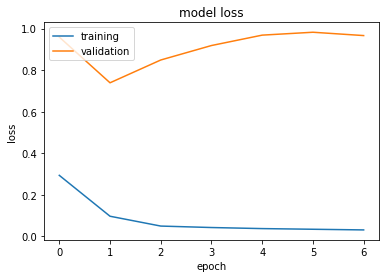

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# performing predictions
predictions1 = model1.predict(X_test) 

# unscaling the predictions
predictions1 = scaler_y.inverse_transform(np.array(predictions1).reshape((len(predictions1), 1)))

# printing the predictions
print('Predictions:',predictions1)


Predictions: [[412.90143]
 [426.70755]
 [420.69446]
 [416.35703]
 [425.2212 ]
 [408.98184]
 [420.47192]
 [403.74567]
 [382.09427]
 [390.84814]
 [419.66382]
 [390.19922]
 [387.45   ]
 [370.93616]
 [380.72308]
 [372.7231 ]
 [375.8552 ]
 [391.9877 ]
 [358.11243]
 [373.66388]
 [351.7741 ]
 [344.70758]
 [354.1962 ]
 [351.4689 ]
 [343.96048]
 [335.7416 ]
 [360.1181 ]
 [349.64313]
 [355.85626]
 [356.47714]
 [348.81024]
 [337.90524]
 [342.06366]
 [343.8606 ]
 [333.89487]
 [334.7994 ]
 [347.99493]
 [321.85995]
 [341.91998]
 [325.24933]
 [338.2821 ]
 [327.18564]
 [334.8642 ]
 [341.02393]
 [349.31287]
 [350.93402]
 [338.315  ]
 [377.0699 ]
 [422.83276]
 [395.25412]
 [374.2857 ]
 [364.58615]
 [367.45526]
 [366.42252]
 [384.82007]
 [370.59073]
 [352.94202]
 [357.27933]
 [352.75027]
 [380.583  ]
 [369.6339 ]
 [363.6562 ]
 [356.74136]
 [345.59277]
 [352.06454]
 [347.814  ]
 [344.66946]
 [344.8426 ]
 [339.52145]
 [368.97983]
 [382.6216 ]
 [344.19373]
 [385.62518]
 [391.01312]
 [411.1947 ]
 [388.7394 ]

### With Sentiment

In [ ]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/JU PROJ/TSLA FinBERT/TOTAL_FINBERT_Tesla_stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,
2017-01-03,43.397999,0.150608,0.209587,0.639805,42.972000,44.066002,42.192001,29616500.0
2017-01-04,45.397999,0.173676,0.187838,0.638485,42.950001,45.599998,42.862000,56067500.0
2017-01-05,45.349998,0.115238,0.162271,0.722491,45.284000,45.495998,44.389999,29558500.0
2017-01-06,45.801998,0.143946,0.211864,0.644191,45.386002,46.062000,45.090000,27639500.0
2017-01-09,46.256001,0.092892,0.182005,0.725102,45.793999,46.383999,45.599998,19897500.0


In [ ]:
stock_data = stock_data.dropna()

In [ ]:
stock_data.isna().any()

Close       False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [ ]:
stock_data= stock_data.astype({"Volume":'float'})

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1346 entries, 2017-01-03 to 2022-05-06
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1346 non-null   float64
 1   negative  1346 non-null   float64
 2   neutral   1346 non-null   float64
 3   positive  1346 non-null   float64
 4   Open      1346 non-null   float64
 5   High      1346 non-null   float64
 6   Low       1346 non-null   float64
 7   Volume    1346 non-null   float64
dtypes: float64(8)
memory usage: 94.6+ KB


In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1076
Number of records in Test Data: 270


In [ ]:
stock_data['Close_EWMA3'] = stock_data['Close'].ewm(span=3, adjust=False).mean()
stock_data['Close_EWMA7'] = stock_data['Close'].ewm(span=7, adjust=False).mean()
stock_data['Close_EWMA14'] = stock_data['Close'].ewm(span=14, adjust=False).mean()
stock_data['Close_EWMA30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()

stock_data['pos_EWMA3'] = stock_data['positive'].ewm(span=3, adjust=False).mean()
stock_data['pos_EWMA7'] = stock_data['positive'].ewm(span=7, adjust=False).mean()
stock_data['pos_EWMA14'] = stock_data['positive'].ewm(span=14, adjust=False).mean()
stock_data['pos_EWMA30'] = stock_data['positive'].ewm(span=30, adjust=False).mean()

stock_data['neu_EWMA3'] = stock_data['neutral'].ewm(span=3, adjust=False).mean()
stock_data['neu_EWMA7'] = stock_data['neutral'].ewm(span=7, adjust=False).mean()
stock_data['neu_EWMA14'] = stock_data['neutral'].ewm(span=14, adjust=False).mean()
stock_data['neu_EWMA30'] = stock_data['neutral'].ewm(span=30, adjust=False).mean()

stock_data['neg_EWMA3'] = stock_data['negative'].ewm(span=3, adjust=False).mean()
stock_data['neg_EWMA7'] = stock_data['negative'].ewm(span=7, adjust=False).mean()
stock_data['neg_EWMA14'] = stock_data['negative'].ewm(span=14, adjust=False).mean()
stock_data['neg_EWMA30'] = stock_data['negative'].ewm(span=30, adjust=False).mean()


# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close

negative = stock_data.iloc[start:total_data,1] #neg
neutral = stock_data.iloc[start:total_data,2] #neu
positive = stock_data.iloc[start:total_data,3] #pos
open_price = stock_data.iloc[start:total_data,4] #open
high = stock_data.iloc[start:total_data,5] #high
low = stock_data.iloc[start:total_data,6] #low
volume = stock_data.iloc[start:total_data,7] #volume

ewma3_close = stock_data.iloc[start:total_data,8]#exponentially moving average 3days
ewma7_close = stock_data.iloc[start:total_data,9]#exponentially moving average 7days
ewma14_close = stock_data.iloc[start:total_data,10]#exponentially moving average 14days
ewma30_close = stock_data.iloc[start:total_data,11]#exponentially moving average 30days

ewma3_pos = stock_data.iloc[start:total_data,12]#exponentially moving average 3days
ewma7_pos = stock_data.iloc[start:total_data,13]#exponentially moving average 7days
ewma14_pos = stock_data.iloc[start:total_data,14]#exponentially moving average 14days
ewma30_pos = stock_data.iloc[start:total_data,15]#exponentially moving average 30days

ewma3_neu = stock_data.iloc[start:total_data,16]#exponentially moving average 3days
ewma7_neu = stock_data.iloc[start:total_data,17]#exponentially moving average 7days
ewma14_neu = stock_data.iloc[start:total_data,18]#exponentially moving average 14days
ewma30_neu = stock_data.iloc[start:total_data,19]#exponentially moving average 30days

ewma3_neg = stock_data.iloc[start:total_data,20]#exponentially moving average 3days
ewma7_neg = stock_data.iloc[start:total_data,21]#exponentially moving average 7days
ewma14_neg = stock_data.iloc[start:total_data,22]#exponentially moving average 14days
ewma30_neg = stock_data.iloc[start:total_data,23]#exponentially moving average 30days

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price,
                  ewma3_close,
                  ewma7_close,
                  ewma14_close,
                  ewma30_close, 
                  close_price_shifted, 

                  positive,
                  ewma3_pos,
                  ewma7_pos,
                  ewma14_pos,
                  ewma30_pos, 

                  negative,
                  ewma3_neg,
                  ewma7_neg,
                  ewma14_neg,
                  ewma30_neg,

                  neutral,
                  ewma3_neu,
                  ewma7_neu,
                  ewma14_neu,
                  ewma30_neu, 

                  volume, 
                  open_price, 
                  high, 
                  low], 
                 axis=1)
data.columns = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
data

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.638485,0.639145,0.639475,0.639629,...,0.152096,0.187838,0.198713,0.204150,0.206687,0.208184,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.722491,0.680818,0.660229,0.650678,...,0.149718,0.162271,0.180492,0.193680,0.200765,0.205222,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.644191,0.662505,0.656220,0.649813,...,0.149346,0.211864,0.196178,0.198226,0.202245,0.205650,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.725102,0.693803,0.673440,0.659851,...,0.145704,0.182005,0.189092,0.194171,0.199546,0.204125,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.725102,0.709453,0.686356,0.668551,...,0.142296,0.182005,0.185548,0.191129,0.197207,0.202698,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.682450,0.678314,0.682759,0.701668,...,0.119038,0.211320,0.212969,0.196035,0.172759,0.164380,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.682450,0.680382,0.682682,0.699105,...,0.118212,0.211320,0.212145,0.199856,0.177901,0.167409,21236500.0,903.179993,924.080017,888.590027
2022-05-04,952.619995,926.774510,922.223103,941.692339,957.781968,873.280029,0.682450,0.681416,0.682624,0.696884,...,0.117439,0.211320,0.211732,0.202722,0.182357,0.170242,27214600.0,903.940002,955.500000,885.280029


In [ ]:
data = data.dropna()

In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2017-01-04     45.349998
2017-01-05     45.801998
2017-01-06     46.256001
2017-01-09     45.973999
2017-01-10     45.945999
                 ...    
2022-04-29    902.940002
2022-05-02    909.250000
2022-05-03    952.619995
2022-05-04    873.280029
2022-05-05    865.650024
Name: close_price_shifted, Length: 1344, dtype: float64

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
x = data[cols]
x

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.638485,0.639145,0.639475,0.639629,...,0.152096,0.187838,0.198713,0.204150,0.206687,0.208184,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.722491,0.680818,0.660229,0.650678,...,0.149718,0.162271,0.180492,0.193680,0.200765,0.205222,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.644191,0.662505,0.656220,0.649813,...,0.149346,0.211864,0.196178,0.198226,0.202245,0.205650,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.725102,0.693803,0.673440,0.659851,...,0.145704,0.182005,0.189092,0.194171,0.199546,0.204125,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.725102,0.709453,0.686356,0.668551,...,0.142296,0.182005,0.185548,0.191129,0.197207,0.202698,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,870.760010,882.276100,916.403654,951.174978,965.548829,902.940002,0.675729,0.674178,0.682862,0.704624,...,0.119921,0.218424,0.214617,0.190940,0.166827,0.161143,29377700.0,902.250000,934.400024,870.000000
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.682450,0.678314,0.682759,0.701668,...,0.119038,0.211320,0.212969,0.196035,0.172759,0.164380,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.682450,0.680382,0.682682,0.699105,...,0.118212,0.211320,0.212145,0.199856,0.177901,0.167409,21236500.0,903.179993,924.080017,888.590027


In [ ]:
from sklearn.preprocessing import StandardScaler
# scaling the feature dataset

scaler_x = preprocessing.StandardScaler ()
x = np.array(x).reshape((len(x) ,len(cols)))

# scaling the target variable
scaler_y = preprocessing.StandardScaler ()
y = np.array (y).reshape ((len( y), 1))

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 45.39799881,  44.39799881,  43.89799881, ...,  42.95000076,
          45.59999847,  42.86199951],
        [ 45.34999847,  44.87399864,  44.26099873, ...,  45.2840004 ,
          45.49599838,  44.38999939],
        [ 45.80199814,  45.33799839,  44.64624858, ...,  45.38600159,
          46.06200027,  45.09000015],
        ...,
        [909.25      , 900.92902549, 912.09080573, ..., 903.17999268,
         924.08001709, 888.59002686],
        [952.61999512, 926.7745103 , 922.22310307, ..., 903.94000244,
         955.5       , 885.2800293 ],
        [873.2800293 , 900.0272698 , 909.98733463, ..., 939.02001953,
         945.59997559, 857.70001221]]), array([[ 45.34999847],
        [ 45.80199814],
        [ 46.25600052],
        ...,
        [952.61999512],
        [873.2800293 ],
        [865.65002441]]))

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1076, 25) and y: (1076, 1)
Number of rows and columns in the Test set X: (267, 25) and y: (267, 1)


In [ ]:
sc = scaler_x.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

sc = scaler_y.fit(y_train)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1076, 25, 1)
Shape of Test set X: (267, 25, 1)


### Model

In [ ]:
import tensorflow as tf
import random 

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

initializer = tf.keras.initializers.GlorotNormal()
model2=Sequential()
model2.add((LSTM(250,return_sequences=True,activation='tanh',kernel_initializer=initializer,input_shape=(len(cols),1))))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(1, activation = 'linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 25, 250)           252000    
                                                                 
 dropout_1 (Dropout)         (None, 25, 250)           0         
                                                                 
 flatten_1 (Flatten)         (None, 6250)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6251      
                                                                 
Total params: 258,251
Trainable params: 258,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
model2.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

history = model2.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=250,
    batch_size=16,
    callbacks=callbacks,
    shuffle = False
)

Epoch 1/250
61/61 [==============================] - 18s 154ms/step - loss: 0.1186 - val_loss: 1.3095
Epoch 2/250
61/61 [==============================] - 7s 108ms/step - loss: 0.0081 - val_loss: 0.0427
Epoch 3/250
61/61 [==============================] - 8s 136ms/step - loss: 0.0060 - val_loss: 0.0370
Epoch 4/250
61/61 [==============================] - 8s 131ms/step - loss: 0.0063 - val_loss: 0.0368
Epoch 5/250
61/61 [==============================] - 7s 119ms/step - loss: 0.0071 - val_loss: 0.0756
Epoch 6/250
61/61 [==============================] - 7s 113ms/step - loss: 0.0116 - val_loss: 0.1444
Epoch 7/250
61/61 [==============================] - 6s 93ms/step - loss: 0.0102 - val_loss: 0.0542
Epoch 8/250
61/61 [==============================] - 4s 65ms/step - loss: 0.0140 - val_loss: 0.2895
Epoch 9/250
61/61 [==============================] - 4s 68ms/step - loss: 0.0074 - val_loss: 0.0323
Epoch 10/250
61/61 [==============================] - 4s 68ms/step - loss: 0.0058 - val_loss:

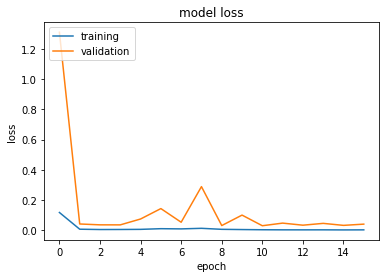

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# performing predictions
predictions2 = model2.predict(X_test) 

# unscaling the predictions
predictions2 = scaler_y.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:',predictions2)


Predictions: [[ 726.01135]
 [ 718.4033 ]
 [ 722.3301 ]
 [ 725.7814 ]
 [ 723.42065]
 [ 721.0481 ]
 [ 727.11395]
 [ 714.98145]
 [ 705.6897 ]
 [ 701.068  ]
 [ 705.6703 ]
 [ 697.0998 ]
 [ 691.83105]
 [ 691.5818 ]
 [ 686.862  ]
 [ 681.52496]
 [ 665.0734 ]
 [ 652.0006 ]
 [ 635.1702 ]
 [ 626.1959 ]
 [ 622.96783]
 [ 615.5648 ]
 [ 611.9621 ]
 [ 605.814  ]
 [ 609.9458 ]
 [ 610.6524 ]
 [ 618.8812 ]
 [ 621.5659 ]
 [ 629.09076]
 [ 634.2487 ]
 [ 634.3029 ]
 [ 631.5387 ]
 [ 622.3697 ]
 [ 612.4697 ]
 [ 615.3974 ]
 [ 617.3634 ]
 [ 618.8865 ]
 [ 615.80286]
 [ 619.7648 ]
 [ 619.9578 ]
 [ 618.1755 ]
 [ 615.4224 ]
 [ 613.16077]
 [ 616.9756 ]
 [ 623.85284]
 [ 621.0436 ]
 [ 623.8417 ]
 [ 639.65234]
 [ 662.3969 ]
 [ 665.7542 ]
 [ 671.46826]
 [ 672.36646]
 [ 674.128  ]
 [ 675.017  ]
 [ 676.0252 ]
 [ 668.32623]
 [ 661.5328 ]
 [ 661.54047]
 [ 665.78613]
 [ 675.97784]
 [ 672.2443 ]
 [ 666.5025 ]
 [ 662.4454 ]
 [ 658.9258 ]
 [ 659.75525]
 [ 663.109  ]
 [ 660.55225]
 [ 656.8587 ]
 [ 654.5521 ]
 [ 660.20215]
 [ 658.

### Performance

In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test+
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

In [ ]:
from sklearn.metrics import mean_absolute_error

print("MAE without sentiment ",mean_absolute_error(y_test,predictions1))
print("MAE with sentiment ",mean_absolute_error(y_test,predictions2))

MAE without sentiment  393.195174085067
MAE with sentiment  42.186940396769664


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE1 = np.square(np.subtract(y_test,predictions1)).mean() 
MSE2 = np.square(np.subtract(y_test,predictions2)).mean() 

print("MSE without sentiment ",MSE1)
print("MSE with sentiment ",MSE2)

RMSE1 = MSE1
RMSE2 = MSE2

print('RMSE without sentiment ', round(np.sqrt(RMSE1),4))
print('RMSE with sentiment ', round(np.sqrt(RMSE2),4))

MSE without sentiment  164710.90396281873
MSE with sentiment  3689.3274760703357
RMSE without sentiment  405.8459
RMSE with sentiment  60.7398


In [ ]:
from sklearn.metrics import r2_score
r2 =[ r2_score(y_test,predictions1), r2_score(y_test,predictions2)]
print('R2 without sentiment ',r2[0])
print('R2 with sentiment ',r2[1])

R2 without sentiment  -4.434496958086329
R2 with sentiment  0.8782737604875601


In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
    
print("MAPE WITHOUT SENTIMENT",MAPE(y_test,predictions1), "%")
print("MAPE WITH SENTIMENT",MAPE(y_test,predictions2), "%")

MAPE WITHOUT SENTIMENT 46.19321647668222 %
MAPE WITH SENTIMENT 4.506591884383843 %


In [ ]:
df = pd.DataFrame(y_data)
df['withoutSentiment'] = predictions1
df['withSentiment'] = predictions2
df['Date'] = df.index
df

,close_price_shifted,withoutSentiment,withSentiment,Date
Date,,,,
2021-04-16,714.630005,412.901428,726.011353,2021-04-16
2021-04-19,718.989990,426.707550,718.403320,2021-04-19
2021-04-20,744.119995,420.694458,722.330078,2021-04-20
2021-04-21,719.690002,416.357025,725.781372,2021-04-21
2021-04-22,729.400024,425.221191,723.420654,2021-04-22
...,...,...,...,...
2022-04-29,902.940002,482.238617,884.203064,2022-04-29
2022-05-02,909.250000,474.514252,886.264465,2022-05-02
2022-05-03,952.619995,475.374146,892.105164,2022-05-03


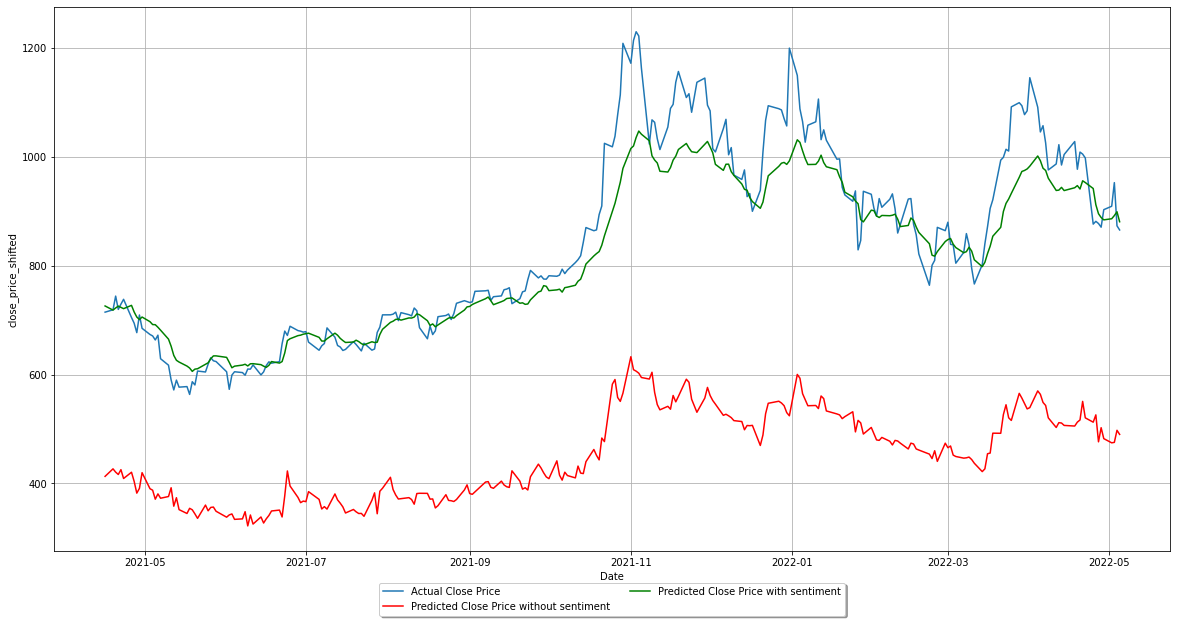

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.lineplot(x='Date', y='close_price_shifted', data = df, label="Actual Close Price")
sns.lineplot(x='Date', y='withoutSentiment', data = df, color = 'red',label="Predicted Close Price without sentiment")
sns.lineplot(x='Date', y='withSentiment', data = df, color = 'green',label="Predicted Close Price with sentiment")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.grid()
plt.show()

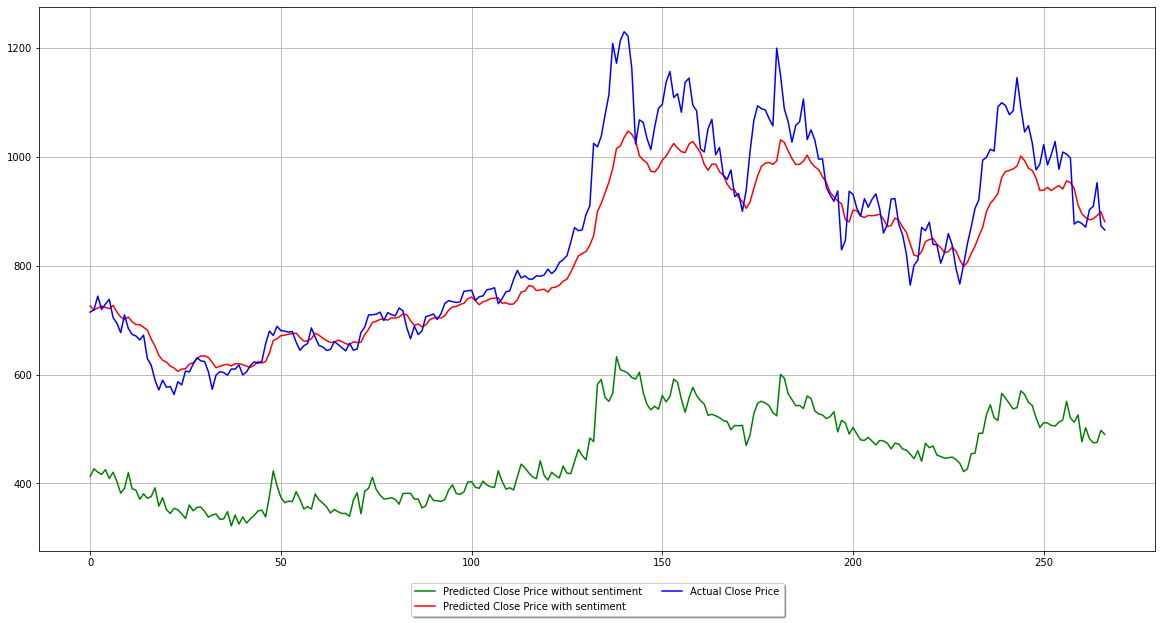

In [ ]:
# plotting
plt.figure(figsize=(20,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions1,'-g', label="Predicted Close Price without sentiment")
plt.plot(predictions2,'-r', label="Predicted Close Price with sentiment")
plt.plot([row[0] for row in y_test],'-b', label="Actual Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.grid()
plt.show()